# **MRI Brain Alzheimer Classification - Kornia Augmentations**

**Import Packages**

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
import matplotlib.pyplot as plt
%matplotlib inline
import random
import time

**Clone Dataset from GitHub**

In [3]:
!git clone https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification
%cd MRI_Brain_Alzheimer_Classification/
if 'utils' not in sys.path:
    sys.path.append('utils')
import utils

Cloning into 'MRI_Brain_Alzheimer_Classification'...
remote: Enumerating objects: 6488, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 6488 (delta 20), reused 47 (delta 13), pack-reused 6433
Receiving objects: 100% (6488/6488), 28.21 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/MRI_Brain_Alzheimer_Classification


**Load the Dataset**

In [4]:
train_set = torch.load('dataset/dataset_variables/train_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')

**Model Definition and Initialization**

In [13]:
class SimpleModel(nn.Module):
    def __init__(self, input_channels=3, output_channels=4):
        super(SimpleModel, self).__init__()

        self.conv_layer = nn.Sequential(
            # 1st main conv layer
            nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=4, num_channels=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 2nd main conv layer
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # 3rd main conv layer
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=16, num_channels=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(512 * 8 * 8, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(1024, output_channels)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [14]:
# Initialize the model
input_channels = 3
output_channels = 4
model = SimpleModel(input_channels, output_channels)

**Define Kornia Augmentations**

In [15]:
kornia_aug = AugmentationSequential(
    K.RandomHorizontalFlip(p=0.5),
    K.RandomVerticalFlip(p=0.5),
    K.ColorJitter(0.1, 0.1, 0.1, 0.1),
    same_on_batch=False,
)

**Hyper-Parameters**

In [16]:
# Hyper-parameters
batch_size = 128
learning_rate = 1e-4
num_epochs = 60

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# loss criterion
criterion = nn.CrossEntropyLoss()
# model
model = model.to(device)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Loading the data and shuffling it
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

**Train Model**

In [17]:
epoch_losses = utils.train(model, num_epochs, trainloader, device, criterion, optimizer, kornia_aug)

Epoch: 1 | Loss: 1.0854 | Training accuracy: 49.554% | Epoch Time: 61.71 secs
Epoch: 2 | Loss: 1.0363 | Training accuracy: 51.406% | Epoch Time: 60.30 secs
Epoch: 3 | Loss: 1.0145 | Training accuracy: 50.826% | Epoch Time: 60.73 secs
Epoch: 4 | Loss: 0.9686 | Training accuracy: 53.996% | Epoch Time: 60.77 secs
Epoch: 5 | Loss: 0.9608 | Training accuracy: 51.071% | Epoch Time: 60.89 secs
Epoch: 6 | Loss: 0.9624 | Training accuracy: 55.156% | Epoch Time: 60.81 secs
Epoch: 7 | Loss: 0.9335 | Training accuracy: 56.763% | Epoch Time: 61.19 secs
Epoch: 8 | Loss: 0.9157 | Training accuracy: 56.362% | Epoch Time: 61.14 secs
Epoch: 9 | Loss: 0.9008 | Training accuracy: 59.040% | Epoch Time: 61.26 secs
Epoch: 10 | Loss: 0.8734 | Training accuracy: 60.424% | Epoch Time: 61.60 secs
Epoch: 11 | Loss: 0.8768 | Training accuracy: 58.906% | Epoch Time: 60.63 secs
Epoch: 12 | Loss: 0.8535 | Training accuracy: 60.246% | Epoch Time: 61.53 secs
Epoch: 13 | Loss: 0.8463 | Training accuracy: 60.223% | Epoch

**Results**

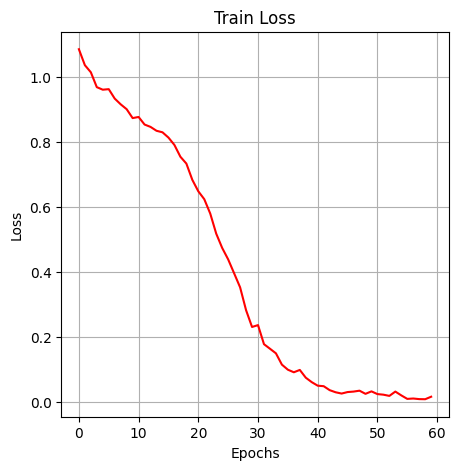

In [18]:
utils.plot_loss_curve(epoch_losses, num_epochs)

In [19]:
test_accuracy = utils.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 96.797%


**Adding a Noise**

In [20]:
noise = 0.1
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        image_n = images + noise * torch.randn(images.size())
        image_n = image_n.to(device)
        labels = labels.to(device)
        outputs = model(image_n)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Test accuracy with a noise: {accuracy:.3f}%")

Test accuracy with a noise: 87.422%
